In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/netflix-shows/netflix_titles.csv


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import chi2
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm

%matplotlib inline

In [15]:
df=pd.read_csv('../input/netflix-shows/netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [16]:
df.director.fillna("No Director", inplace=True)


df.cast.fillna("No Cast", inplace=True)


df.country.fillna("Country Unavailable", inplace=True)


df.dropna(inplace=True)

df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [17]:
df_movies=df.query("type=='Movie'")
df_tvshow=df.query("type=='TV Show'")

print(df_movies.type.value_counts())
print(df_tvshow.type.value_counts())


df['country'].value_counts()

Movie    5372
Name: type, dtype: int64
TV Show    2398
Name: type, dtype: int64


United States                                                  2546
India                                                           923
Country Unavailable                                             505
United Kingdom                                                  396
Japan                                                           224
                                                               ... 
Israel, Germany, France                                           1
Ireland, Canada, United States, United Kingdom                    1
France, Belgium, Luxembourg, Romania, Canada, United States       1
Turkey, France, Germany, Poland                                   1
France, Brazil, Spain, Belgium                                    1
Name: country, Length: 682, dtype: int64

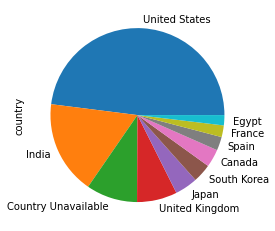

In [18]:
con=df['country'].value_counts()

con.head(10).plot.pie()
import matplotlib.pyplot as plt


In [19]:
def get_data():
    movies = pd.read_csv('../input/netflix-shows/netflix_titles.csv')
    
   
    movies.dropna(inplace=True)
    
  
    movies['rating'].replace(to_replace='PG-13', value='TV-PG', inplace=True)
    movies['rating'].replace(to_replace='PG', value='TV-PG', inplace=True)
    movies['rating'].replace(to_replace='TV-Y7-FV', value='TV-Y7', inplace=True)
    movies['rating'].replace(to_replace='G', value='TV-G', inplace=True)
    movies['rating'].replace(to_replace='NC-17', value='R', inplace=True)
   
    movies.drop(movies[movies['rating']=='NR'].index, inplace=True)
    movies.drop(movies[movies['rating']==''].index, inplace=True)
    movies.drop(movies[movies['rating']=='UR'].index, inplace=True)
    
    
    
 
    movies.drop(movies[movies['rating']=='TV-G'].index, inplace=True)
    movies.drop(movies[movies['rating']=='TV-Y'].index, inplace=True)
    movies.drop(movies[movies['rating']=='TV-Y7'].index, inplace=True)


 
    movies = movies[["type", "title", "description", "director", "cast", 'rating', "listed_in", "country"]]
    
    return movies

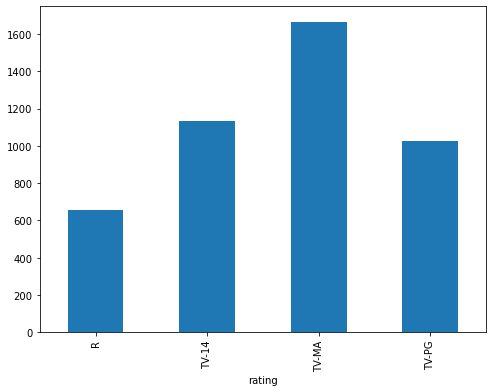

In [21]:
movies = get_data()


fig = plt.figure(figsize=(8,6))
movies.groupby('rating').title.count().plot.bar(ylim=0)
plt.show()

In [22]:
movies['category_id'] = movies['rating'].factorize()[0]

category_id_df = movies[["rating", "category_id"]].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'rating']].values)
labels = movies.category_id

In [23]:
movies ['txt'] = movies['type'] + " " + movies['title'] + " " + movies['description'] + " " + movies['listed_in'] 
movies['txt'] = movies['txt'] + " " + movies['director'] + " " + movies['cast'] + " " + movies["country"]
movies = movies[['rating', 'txt']]


mskf = KFold(n_splits = 15, random_state=0, shuffle = True)
acc = []

for train_index, test_index in mskf.split(movies['txt']) :
    X_train, X_test = movies['txt'].iloc[train_index], movies['txt'].iloc[test_index]
    y_train, y_test = movies['rating'].iloc[train_index], movies['rating'].iloc[test_index]

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    
  
    clf = MultinomialNB().fit(X_train_tfidf, y_train)
    
   
    acc.append(clf.score(count_vect.transform(X_test.values), y_test.values))

In [24]:
print("Accuracy with Naive Bayes: " + str(np.mean(acc) * 100) + "%")

Accuracy with Naive Bayes: 51.49551450397672%
